<img src='./img/c3s_header.png' align='center' width='100%'></img>

<br>

# CORDEX: Regional climate projections

### About

This notebook provides you a practical introduction to [CORDEX regional climate model data on single levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cordex-domains-single-levels?tab=overview). CORDEX data are available for 14 regional domains and variable spatial resolutions, from 0.11 x 0.11 degrees up to 0.44 x 0.44 degrees. This workflow shows you how to compute the difference of air temperature climatology for 2071-2100 relative to the reference period 1971-2000 in Africa, with a spatial resolution of 0.22 x 0.22 degrees. 

You will use historical experiment to compute the climatology for the period 1971 to 2000, the scenario RCP4.5 to compute the future climatology for the period 2071 to 2100 and you take the difference between the two climatologies. This is called the "delta method" which takes the climate change signal as the difference between the future and past considering that the model biases are the same in the past and the future and therefore they disappear with the subtraction.

The example showcases data from the Canadian Regional Climate Model `CCCma_CanRCM4`. See [here](https://confluence.ecmwf.int/display/CKB/CORDEX%3A+Regional+climate+projections#CORDEX:Regionalclimateprojections-DrivingGlobalClimateModelsandRegionalClimateModels) a full list of models included in the CDS-CORDEX subset.

**Note:** The workflow uses a specific model, scenario and geographical area, but you can use any model, any secneario, any domain, any period or variable.

<br>

In general, CORDEX experiments can be divided in three main categories:

* **Evaluation**: model simulations for the past with imposed "perfect" lateral boundary condition following ERA-Interim reanalyses (1979-2015).

* **Historical**: Historical experiments cover the period where modern climate observations exist. These experiements show how the RCMs perform for the past climate when forced by the Global Circulation Model (GCM) and can be used as reference period for comparison with scenario runs for the future. 

* **Scenario experiments RCP2.6, RCP4.5, RCP8.5**: ensemble of CORDEX climate projection experiments driven by boundary conditions from GCMs using RCP (Representative Concentration Pathways) forcing scenarios. The scenarios used here are RCP 2.6, 4.5 and 8.5, which provide different pathways of the future climate forcing.

Learn [here](https://confluence.ecmwf.int/display/CKB/CORDEX%3A+Regional+climate+projections#CORDEX:Regionalclimateprojections-Experiments) more about CORDEX experiments in the Copernicus Climate Data Store.



The notebook has the following outline:
* [1 - Request data from the CDS programmatically with the CDS API](#request_data_cordex)
* [2 - Unzip the downloaded data files](#unzip_cordex)
* [3 - Compute CORDEX historical climatology for reference period 1971-2000](#cordex_historical_climatology)
* [4 - Compute CORDEX future climatology for target period 2071-2100 based on scenario RCP4.5](#cordex_future_climatology)
* [5 - Compute and visualize the climate change signal between the target period (2](#cordex_visualize_difference)

### Data

This notebook introduces you to [CORDEX regional climate model data on single levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cordex-domains-single-levels?tab=overview). The data used in the notebook has the following specifications:

> **Data**: `CORDEX regional climate model data on single levels - Experiment: Historical` <br>
> **Temporal coverage**: `1 Jan 1971 to 31 Dec 2000` <br>
> **Spatial coverage**: `Domain: Africa` <br>
> **Format**: `zip`


> **Data**: `CORDEX regional climate model data on single levels - Experiment: RCP4.5` <br>
> **Temporal coverage**: `1 Jan 2071 to 31 Dec 2100` <br>
> **Spatial coverage**: `Domain: Africa` <br>
> **Format**: `zip`
<br>


### How to access the notebook
* [**nbviewer**](https://nbviewer.org/github/ecmwf-projects/copernicus-training/blob/master/132_c3s_regional_climate_projections.ipynb)
* [**Colab**](https://colab.research.google.com/github/ecmwf-projects/copernicus-training/blob/master/132_c3s_regional_climate_projections.ipynb)
* [**Binder**](https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training/HEAD?urlpath=lab/tree/132_c3s_regional_climate_projections.ipynb)
* [**Kaggle**](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training/blob/master/132_c3s_regional_climate_projections.ipynb)

<hr>

### Install CDS API via pip

In [ ]:
!pip install cdsapi

### Load libraries

In [2]:
# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# Libraries for paths and filenames
from glob import glob
from pathlib import Path
from os.path import basename

<hr>

## <a id='request_data_cordex'></a> 1. Request data from the CDS programmatically with the CDS API

The first step is to request data from the Climate Data Store programmatically with the help of the CDS API. Let us make use of the option to manually set the CDS API credentials. First, you have to define two variables: `URL` and `KEY` which build together your CDS API key. Below, you have to replace the `#########` with your personal CDS key. Please find [here](https://cds.climate.copernicus.eu/api-how-to) your personal CDS key.

In [22]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '##################################'

<br>

The next step is then to request the data with the help of the CDS API. Below, we run two data requests:
* **Historical experiment**: Daily aggregated historical 2m air temperature (from the CCCma-CanESM2 - Canada model) from 1971 to 2000 for Africa.
* **RCP4.5 experiment**: Daily aggregated RCP4.5 projections of 2m air temperature (from the CCCma-CanESM2 - Canada model) from 2071 to 2100 for Africa

CORDEX data are disseminated as netcdf files within a zip archive.

In [ ]:
c = cdsapi.Client(url=URL, key=KEY)

# Historical experiment
c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'format': 'zip',
        'end_year': [
            '1975', '1980', '1985', '1990', '1995', '2000'
        ],
        'start_year': [
            '1971', '1976', '1981', '1986', '1991', '1996'
        ],
        'ensemble_member': 'r1i1p1',
        'rcm_model': 'cccma_canrcm4',
        'gcm_model': 'cccma_canesm2',
        'variable': '2m_air_temperature',
        'horizontal_resolution': '0_44_degree_x_0_44_degree',
        'temporal_resolution': 'daily_mean',
        'domain': 'africa',
        'experiment': 'historical',
    },
    './1971-2000_cordex_rcp_4_5_africa.zip')

# Experiment: RCP4.5
c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'domain': 'africa',
        'experiment': 'rcp_4_5',
        'horizontal_resolution': '0_44_degree_x_0_44_degree',
        'temporal_resolution': 'daily_mean',
        'variable': '2m_air_temperature',
        'gcm_model': 'cccma_canesm2',
        'rcm_model': 'cccma_canrcm4',
        'ensemble_member': 'r1i1p1',
        'start_year': ['2071', '2076', '2081', '2086', '2091', '2096'],
        'end_year': ['2075', '2080', '2085', '2090', '2095','2100'],
        'format': 'zip',
    },
    './2071-2100_cordex_rcp_4_5_africa.zip')

<br>

## <a id='unzip_cordex'></a>2. Unzip the downloaded data files

From the Copernicus Climate Data Store, CORDEX data are available either as compressed `zip` archive or compressed `tar.gz` archive. For this reason, before we can load any data, we have to unzip or untar the files. Once you downloaded the two experiments `historical` and `RCP4.5` as seperate zip files (see CDSAPI requests [here](./100_climate_data_store_intro.ipynb#climate_projections)), you can use the functions from the `zipfile` Python package to extract the content of a zip file. First, you construct a `ZipFile()` object and second, you apply the function `extractall()` to extract the content of the zip file.

Below, the same process is repeated for the two zip files downloaded. You see that the actual data files are disseminated in `NetCDF`. CORDEX files are generally organised in five year periods. For this reason, for each zip file, six `NetCDF` files in five year periods are extracted.

In [7]:
import zipfile
with zipfile.ZipFile('./1971-2000_cordex_rcp_4_5_africa.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [8]:
import zipfile
with zipfile.ZipFile('./2071-2100_cordex_rcp_4_5_africa.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

<br>

## <a id='cordex_historical_climatology'></a>3. Compute CORDEX historical climatology for reference period 1971-2000

The first step is to load the data of the `historical` experiment.

CORDEX data, once unzipped, are disseminated in `NetCDF`. You can use the Python library [xarray](http://xarray.pydata.org/en/stable/) and its function `open_mfdataset` to read multiple NetCDF files at once. With the keyword argument `concat_dim`, you can specify the dimension at which the data shall be concatenated on. In the case of the CORDEX data, since the data files are split based on years, you want to concatenate the data at the dimension `time`.

The result is a `xarray.Dataset` object with four dimensions: `bnds`, `rlat`, `rlon`, `time`, of which the dimension `bnds` is not callable.

In [10]:
ds_1971_2000_historical = xr.open_mfdataset('./*CanESM2_historical*.nc', concat_dim='time')
ds_1971_2000_historical

<xarray.Dataset>
Dimensions:       (bnds: 2, rlat: 201, rlon: 194, time: 10950)
Coordinates:
  * time          (time) object 1971-01-01 12:00:00 ... 2000-12-31 12:00:00
  * rlon          (rlon) float64 -24.64 -24.2 -23.76 -23.32 ... 59.4 59.84 60.28
  * rlat          (rlat) float64 -45.76 -45.32 -44.88 ... 41.36 41.8 42.24
    lon           (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    lat           (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    height        float64 2.0
Dimensions without coordinates: bnds
Data variables:
    rotated_pole  (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b'' b''
    tas           (time, rlat, rlon) float32 dask.array<chunksize=(1825, 201, 194), meta=np.ndarray>
    time_bnds     (time, bnds) object dask.array<chunksize=(1825, 2), meta=np.ndarray>
Attributes: (12/26)
    title:                          CanRCM4 model output prepared for CORDEX ...
    institution:                    CCCma (Canadian Centre for Climate Modell...
    institute_id:                   CCCma
    contact:                        cccma_info@ec.gc.ca
    Conventions:                    CF-1.4
    experiment:                     Historical run driven by CCCma-CanESM2
    ...                             ...
    history:                        created: 2012-06-29 23:52:08 by rcm2nc
    data_licence:                   1) GRANT OF LICENCE - The Government of C...
    creation_date:                  2012-06-29-T23:47:03Z
    c3s_comment:                    This data has been published at ESGF with...
    tracking_id:                    hdl:21.14103/3d35a8d3-105d-451c-88fa-4d46...
    c3s_disclaimer:                 This data has been curated and prepared i...

The next step is to load the data variable `tas` from the Dataset above. You can load a data variables by adding the name of the variable (`tas`) in square brackets. The resulting object is a `xarray.DataArray`, which offers additional metadata information about the data, e.g. the `unit` or `long_name` of the variable.

In [11]:
tas_1971_2000_historical = ds_1971_2000_historical['tas']
tas_1971_2000_historical

<xarray.DataArray 'tas' (time: 10950, rlat: 201, rlon: 194)>
dask.array<concatenate, shape=(10950, 201, 194), dtype=float32, chunksize=(1825, 201, 194), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1971-01-01 12:00:00 ... 2000-12-31 12:00:00
  * rlon     (rlon) float64 -24.64 -24.2 -23.76 -23.32 ... 59.4 59.84 60.28
  * rlat     (rlat) float64 -45.76 -45.32 -44.88 -44.44 ... 41.36 41.8 42.24
    lon      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    lat      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    height   float64 2.0
Attributes:
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K
    grid_mapping:   rotated_pole
    cell_methods:   time: mean

Let us inspect the time dimension. You can see that the time dimension has 10950 entries and represents daily data from 1 January 1971 to 31 December 2000.

In [12]:
tas_1971_2000_historical.time

<xarray.DataArray 'time' (time: 10950)>
array([cftime.DatetimeNoLeap(1971, 1, 1, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1971, 1, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1971, 1, 3, 12, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2000, 12, 29, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 12, 30, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 12, 31, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1971-01-01 12:00:00 ... 2000-12-31 12:00:00
    height   float64 2.0
Attributes:
    long_name:      time
    standard_name:  time
    axis:           T
    bounds:         time_bnds

In a next step, we want to compute the monthly climatology for the reference period. The monthly climatology represents for each month the average value over the reference period of 30 years, from 1971 to 2000. You can compute the climatology with xarray in two steps: first, all the values for one specific month have to be grouped with the function `groupby()` and second, you can create the average of each group with the function `mean()`.

The result is a three-dimensional DataArray with the dimensions `month`, `rlat` and `rlon`. The operation has changed the name of the `time` dimension to `month`, which has the average near-surface air temperature for each month. Please note that this operation also drops all the attributes from the DataArray.

In [13]:
tas_1971_2000_climatology = tas_1971_2000_historical.groupby('time.month').mean()
tas_1971_2000_climatology

<xarray.DataArray 'tas' (month: 12, rlat: 201, rlon: 194)>
dask.array<stack, shape=(12, 201, 194), dtype=float32, chunksize=(1, 201, 194), chunktype=numpy.ndarray>
Coordinates:
  * rlon     (rlon) float64 -24.64 -24.2 -23.76 -23.32 ... 59.4 59.84 60.28
  * rlat     (rlat) float64 -45.76 -45.32 -44.88 -44.44 ... 41.36 41.8 42.24
    lon      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    lat      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    height   float64 2.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In a last step, we want to convert the near-surface air temperature values in Kelvin to degrees Celsisus. You can do this by subtracting 273.15 from air temperature values in Kelvin.

In [14]:
tas_1971_2000_climatology_degC = tas_1971_2000_climatology - 273.15
tas_1971_2000_climatology_degC

<xarray.DataArray 'tas' (month: 12, rlat: 201, rlon: 194)>
dask.array<sub, shape=(12, 201, 194), dtype=float32, chunksize=(1, 201, 194), chunktype=numpy.ndarray>
Coordinates:
  * rlon     (rlon) float64 -24.64 -24.2 -23.76 -23.32 ... 59.4 59.84 60.28
  * rlat     (rlat) float64 -45.76 -45.32 -44.88 -44.44 ... 41.36 41.8 42.24
    lon      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    lat      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    height   float64 2.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

<br>

## <a id='cordex_future_climatology'></a>4. Compute CORDEX future climatology for target period 2071-2100 based on scenario RCP4.5

Let us now repeat the steps executed for the historical experiment data with the `scenario RCP4.5` data. With the projection data for the target period 2071 to 2100, we can compute the future climatology which can be compared with the historical climatology from the reference period.
You can use again the function `open_mfdataset()` to load multiple `NetCDF` files. The scenario data is also organised based on 5-year periods. Hence, the dimension to concatenate the data is `time`.

The result is a `xarray.Dataset` object with four dimensions: `bnds`, `rlat`, `rlon`, `time`, of which the dimension `bnds` is not callable.

In [15]:
ds_2071_2100_projection = xr.open_mfdataset('./*CanESM2_rcp45*.nc', concat_dim='time')
ds_2071_2100_projection

<xarray.Dataset>
Dimensions:       (bnds: 2, rlat: 201, rlon: 194, time: 10950)
Coordinates:
  * time          (time) object 2071-01-01 12:00:00 ... 2100-12-31 12:00:00
  * rlon          (rlon) float64 -24.64 -24.2 -23.76 -23.32 ... 59.4 59.84 60.28
  * rlat          (rlat) float64 -45.76 -45.32 -44.88 ... 41.36 41.8 42.24
    lon           (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    lat           (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    height        float64 2.0
Dimensions without coordinates: bnds
Data variables:
    rotated_pole  (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b'' b''
    tas           (time, rlat, rlon) float32 dask.array<chunksize=(1825, 201, 194), meta=np.ndarray>
    time_bnds     (time, bnds) object dask.array<chunksize=(1825, 2), meta=np.ndarray>
Attributes: (12/26)
    title:                          CanRCM4 model output prepared for CORDEX ...
    institution:                    CCCma (Canadian Centre for Climate Modell...
    institute_id:                   CCCma
    contact:                        cccma_info@ec.gc.ca
    Conventions:                    CF-1.4
    experiment:                     RCP4.5 run driven by CCCma-CanESM2 
    ...                             ...
    history:                        created: 2012-06-29 23:55:49 by rcm2nc
    data_licence:                   1) GRANT OF LICENCE - The Government of C...
    creation_date:                  2012-06-29-T23:48:22Z
    c3s_comment:                    This data has been published at ESGF with...
    tracking_id:                    hdl:21.14103/7bd05374-ef0d-4b0a-80fc-5e08...
    c3s_disclaimer:                 This data has been curated and prepared i...

The next step is to load the data variable `tas` from the Dataset above. You can load a data variable by adding the name of the variable (`tas`) in square brackets. The resulting object is a `xarray.DataArray`, which offers additional metadata information about the data, e.g. the `unit` or `long_name` of the variable.

In [16]:
tas_2071_2100_projection = ds_2071_2100_projection['tas']
tas_2071_2100_projection

<xarray.DataArray 'tas' (time: 10950, rlat: 201, rlon: 194)>
dask.array<concatenate, shape=(10950, 201, 194), dtype=float32, chunksize=(1825, 201, 194), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2071-01-01 12:00:00 ... 2100-12-31 12:00:00
  * rlon     (rlon) float64 -24.64 -24.2 -23.76 -23.32 ... 59.4 59.84 60.28
  * rlat     (rlat) float64 -45.76 -45.32 -44.88 -44.44 ... 41.36 41.8 42.24
    lon      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    lat      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    height   float64 2.0
Attributes:
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K
    grid_mapping:   rotated_pole
    cell_methods:   time: mean

Let us also inspect the time dimension for the projection data. The dimension has the same number of entries as the historical data, 10950. Hence, the scenario data are daily aggregates for the years 2071 to 2100.

In [17]:
tas_2071_2100_projection.time

<xarray.DataArray 'time' (time: 10950)>
array([cftime.DatetimeNoLeap(2071, 1, 1, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2071, 1, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2071, 1, 3, 12, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 12, 29, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 30, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 31, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2071-01-01 12:00:00 ... 2100-12-31 12:00:00
    height   float64 2.0
Attributes:
    long_name:      time
    standard_name:  time
    axis:           T
    bounds:         time_bnds

In a next step, we want to compute the monthly climatology for the target period 2071 to 2100. The monthly climatology represents for each month the average value over the target period of 30 years, from 2071 to 2100. In xarray, you can compute a climatology in two steps: first, all the values for one specific month have to be grouped with the function `groupby()` and second, you can create the average of each group with the function `mean()`.

The result is a three-dimensional DataArray with the dimensions `month`, `rlat` and `rlon`. The operation has changed the name of the `time` dimension to `month`, which has the average near-surface air temperature for each month. Please note that this operation also drops all the attributes from the DataArray.

In [18]:
tas_2071_2100_climatology = tas_2071_2100_projection.groupby('time.month').mean()
tas_2071_2100_climatology

<xarray.DataArray 'tas' (month: 12, rlat: 201, rlon: 194)>
dask.array<stack, shape=(12, 201, 194), dtype=float32, chunksize=(1, 201, 194), chunktype=numpy.ndarray>
Coordinates:
  * rlon     (rlon) float64 -24.64 -24.2 -23.76 -23.32 ... 59.4 59.84 60.28
  * rlat     (rlat) float64 -45.76 -45.32 -44.88 -44.44 ... 41.36 41.8 42.24
    lon      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    lat      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    height   float64 2.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In a last step, we also want to convert the future climatology values from Kelvin to degrees Celsius by subtracting 273.15 from the near-surface air temperature in Kelvin.

In [19]:
tas_2071_2100_climatology_degC = tas_2071_2100_climatology - 273.15
tas_2071_2100_climatology_degC

<xarray.DataArray 'tas' (month: 12, rlat: 201, rlon: 194)>
dask.array<sub, shape=(12, 201, 194), dtype=float32, chunksize=(1, 201, 194), chunktype=numpy.ndarray>
Coordinates:
  * rlon     (rlon) float64 -24.64 -24.2 -23.76 -23.32 ... 59.4 59.84 60.28
  * rlat     (rlat) float64 -45.76 -45.32 -44.88 -44.44 ... 41.36 41.8 42.24
    lon      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    lat      (rlat, rlon) float64 dask.array<chunksize=(201, 194), meta=np.ndarray>
    height   float64 2.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

<br>

## <a id='cordex_visualize_difference'></a>5. Compute and visualize the climate change signal between the target (2071-2100) and reference (1971-2000) period

Now, we can compute the difference between the two climatologies. Since both DataArrays have the same structure, we can simply subtract the historical climatology from the 'projected' future climatology. The resulting data array has the projected averaged temperature difference for each month.

In [20]:
tas_difference_climatology = tas_2071_2100_climatology - tas_1971_2000_climatology
tas_difference_climatology

<xarray.DataArray 'tas' (month: 12, rlat: 201, rlon: 194)>
dask.array<sub, shape=(12, 201, 194), dtype=float32, chunksize=(1, 201, 194), chunktype=numpy.ndarray>
Coordinates:
  * rlon     (rlon) float64 -24.64 -24.2 -23.76 -23.32 ... 59.4 59.84 60.28
  * rlat     (rlat) float64 -45.76 -45.32 -44.88 -44.44 ... 41.36 41.8 42.24
    lon      (rlat, rlon) float64 335.4 335.8 336.2 336.7 ... 59.4 59.84 60.28
    lat      (rlat, rlon) float64 -45.76 -45.76 -45.76 ... 42.24 42.24 42.24
    height   float64 2.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

Now, let us visualize the climate change signal between the target (2071-2100) and reference (1971-2000) period for Africa for June. The plotting function below has fiver main parts:
* **Initiate the plot**: initiate a matplotlib plot with `plt.figure` and `plt.subplot()`
* **Plot the 2D map with pcolormesh**: plot the xarray data array as 2D map with the function pcolormesh
* **Add coast- and gridlines**: add additional items to the plot, such as coast- and gridlines
* **Add title and legend**: Set title and legend of the map
* **Save the figure as png file**

You can change the value for the variable month and you see that the near-surface air temperature difference is for some regions more pronounced for some months, e.g. June, compared to others.

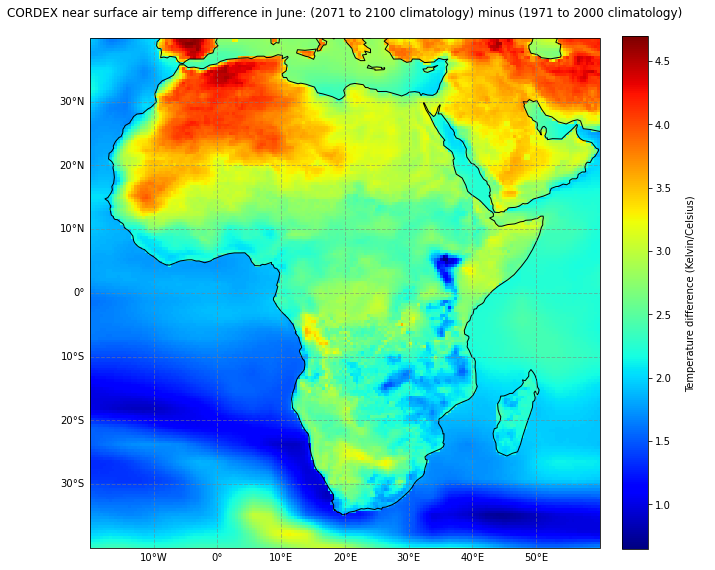

In [27]:
month=5

# Initiate the plot
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

# Plot the 2D map with pcolormesh
im = plt.pcolormesh(tas_difference_climatology.rlon, tas_difference_climatology.rlat,
                   tas_difference_climatology[month,:,:], cmap='jet', transform=ccrs.PlateCarree())


# Add coast- and gridlines
ax.coastlines(color='black')
ax.set_extent([-20,60,-40,40], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add title and legend
ax.set_title('CORDEX near surface air temp difference in June: (2071 to 2100 climatology) minus (1971 to 2000 climatology)\n', fontsize=12)
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('\nTemperature difference (Kelvin/Celsius)\n')

# Save the figure
fig.savefig('./TAS_1971-2000_2071-2100_june.png', dpi=300)

<br>

As a last step, we repeat the visualization of climate change signal between the target (2071-2100) and reference (1971-2000) period. But this time, we create the average signal for the whole period, not only one month. For this, you have to compute the average over all months with the function `mean()`.

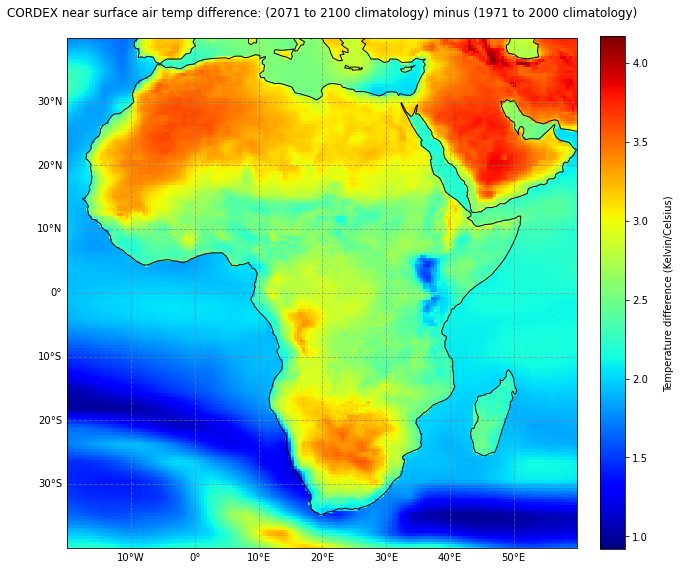

In [28]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

ax.coastlines(color='black')
ax.set_extent([-20,60,-40,40], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_title('CORDEX near surface air temp difference: (2071 to 2100 climatology) minus (1971 to 2000 climatology)\n', fontsize=12)

im = plt.pcolormesh(tas_difference_climatology.rlon, tas_difference_climatology.rlat,
                   tas_difference_climatology.mean('month'), cmap='jet', transform=ccrs.PlateCarree())

cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('\nTemperature difference (Kelvin/Celsius)\n')

fig.savefig('./TAS_1971-2000_2071-2100.png', dpi=300)

<br>

<hr>

<p><img src='./img/copernicus_logo.png' align='right' alt='Logo EU Copernicus' width='20%'></img></p>
<br><br><br><br><br>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>